# 各种流变模型的模拟数据生成

## 生成幂律模型的应力应变数据
$$\sigma=K\gamma^n$$


+ 导包

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

+ 定义公共对象

In [2]:
# 创建Excel写入器
writer = pd.ExcelWriter('data/power_law_data.xlsx', engine='xlsxwriter')
# 获取xlsxwriter工作簿和工作表对象
workbook = writer.book
# 定义格式
format1 = workbook.add_format({'num_format': '0.000000000000000'})

ModuleNotFoundError: No module named 'xlsxwriter'

In [ ]:
# 参数
K = 1.0  # 材料常数
n_values = [0.3, 0.5, 1.0, 1.5, 2.0]  # 幂律指数列表
epsilon_max = 100  # 最大剪切率
num_points = 10000   # 数据点数量

# 生成应变数据
epsilon = np.linspace(1, epsilon_max, num_points)

# 获取当前Jupyter Notebook文件的绝对路径

# 绘制应力-应变曲线
plt.figure(figsize=(10, 6))

for n in n_values:
    # 根据幂律模型生成应力数据
    sigma = K * epsilon**n
   
    # 创建DataFrame
    data = pd.DataFrame({'shear rate': epsilon, 'stress': sigma,'n':[n]*len(sigma)})
    
    # 将数据写入Excel文件的不同工作簿
    data.to_excel(writer, sheet_name=f'n={n}', index=False, float_format='%.15f')
    
    # 绘制曲线
    plt.plot(epsilon, sigma, label=f'n = {n}', linewidth=2)

# 保存Excel文件
writer.close()

plt.xlabel('shear rate')
plt.ylabel('stress')
plt.yscale('log')
plt.title('Stress-Strain Curves for Different Power Law Indices')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'writer' is not defined

<Figure size 720x432 with 0 Axes>

## 生成宾汉塑性流体模型
$$\sigma=\sigma_0+K\gamma^n$$

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'svg'
# 检查系统是否安装了 Arial 字体
def is_arial_available():
    for font in fm.fontManager.ttflist:
        if 'Arial' in font.name:
            return True
    return False

# 如果系统没有 Arial 字体，加载用户自定义字体
if not is_arial_available():
    user_font_path = os.path.expanduser('~/.local/share/fonts/ARIAL.TTF')
    if os.path.exists(user_font_path):
        # 添加用户字体到 Matplotlib 的字体管理器
        fm.fontManager.addfont(user_font_path)
        # 设置 Matplotlib 使用该字体
        plt.rcParams['font.family'] = 'sans-serif'
        plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
        print("已加载用户自定义 Arial 字体")
    else:
        print("未找到用户自定义 Arial 字体文件")
else:
    print("系统已安装 Arial 字体")

已加载用户自定义 Arial 字体


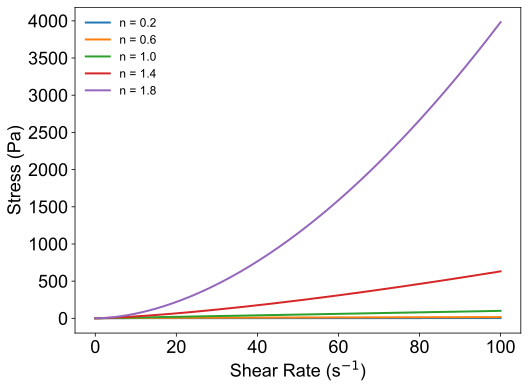

In [23]:
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial
plt.rcParams['font.size'] = 18
%config InlineBackend.figure_format = 'svg'
# 参数
K = 1.0  # 材料常数
n_values = [0.2, 0.6, 1.0, 1.4, 1.8]  # 幂律指数列表
epsilon_max = 100  # 最大应变
num_points = 10000   # 数据点数量
sigma0=1
# 生成应变数据
epsilon = np.linspace(0, epsilon_max, num_points)

# 创建Excel写入器
#writer = pd.ExcelWriter('data/bingham_data.xlsx', engine='xlsxwriter')

# 绘制应力-应变曲线
plt.figure(figsize=(8, 6),dpi=600)

for n in n_values:
    # 根据幂律模型生成应力数据
    sigma = sigma0+K * epsilon**n
    
    # 创建DataFrame
    data = pd.DataFrame({'shear rate': epsilon, 'stress': sigma,'n':[n]*len(sigma)})
    
    # 将数据写入Excel文件的不同工作簿
    #data.to_excel(writer, sheet_name=f'n={n}', index=False, float_format='%.15f')
    # 绘制曲线
    plt.plot(epsilon, sigma, label=f'n = {n}', linewidth=2)

# 保存Excel文件
#writer.close()

plt.xlabel('Shear Rate (s$^{-1}$)')
plt.ylabel('Stress (Pa)')
# plt.yscale('log')
plt.legend(loc='upper left', frameon=False,fontsize=12)
plt.savefig('pic/herschel_moni.pdf')
plt.show()

+ 测试一下数据的精度

In [44]:
# 读取Excel文件
file_path = 'data/bingham_data.xlsx'
df = pd.read_excel(file_path, sheet_name=0)  # 读取第一个工作簿

# 打印前10行数据
print(df.head(10))

   Strain (γ)  Stress (σ)
0    1.000000    2.000000
1    1.009901    2.001972
2    1.019802    2.003929
3    1.029703    2.005871
4    1.039604    2.007798
5    1.049505    2.009711
6    1.059406    2.011609
7    1.069307    2.013492
8    1.079208    2.015362
9    1.089109    2.017219


## 简单MaxWell模型

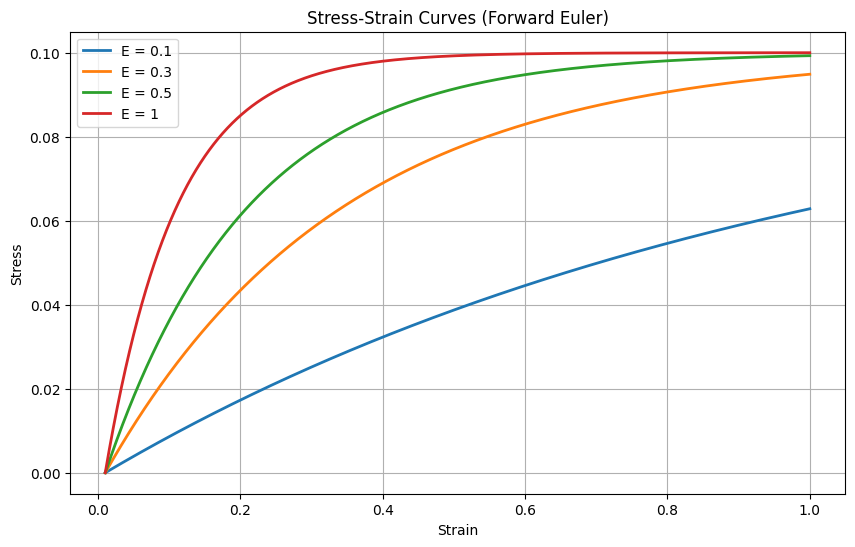

In [4]:
# 定义 calc_stress 函数
def calc_stress(E, eta, max_strain, strain_rate, N):
    time = np.linspace(0.1,  max_strain / strain_rate, N)
    strain = np.zeros(N)
    for i in range(N):
        if time[i] < max_strain / strain_rate:
            strain[i] = strain_rate * time[i]
        else:
            strain[i] = max_strain - (time[i] - max_strain / strain_rate) * strain_rate
    
    stress = np.zeros(N)
    for i in range(1, N):
        de = strain[i] - strain[i-1]
        dt = time[i] - time[i-1]
        stress[i] = (1 - dt / (eta / E)) * stress[i-1] + E * de
    
    return time, strain, stress

# 参数
E_values = [0.1, 0.3, 0.5, 1]  # 弹性模量列表
eta = 1  # 粘性系数
max_strain = 1  # 最大应变
strain_rate = 0.1  # 应变率
N = 10000  # 时间步数

# 创建Excel写入器
writer = pd.ExcelWriter('data/simple_maxwell_data.xlsx', engine='xlsxwriter')

# 绘制应力-应变曲线
plt.figure(figsize=(10, 6))

for E in E_values:
    # 计算应力-应变数据
    time, strain, stress = calc_stress(E, eta, max_strain, strain_rate, N)
    
    # 创建DataFrame
    data = pd.DataFrame({'Strain': strain, 'Stress': 10*stress,'n':[E]*len(stress)})
    
    # 将数据写入Excel文件的不同工作簿
    data.to_excel(writer, sheet_name=f'E={E}', index=False)
    
    # 绘制曲线
    plt.plot(strain, stress, label=f'E = {E}', linewidth=2)

# 保存Excel文件
writer.close()

plt.xlabel('Strain')
plt.ylabel('Stress')
plt.title('Stress-Strain Curves (Forward Euler)')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# 读取Excel文件
file_path = 'data/simple_maxwell_data.xlsx'
df = pd.read_excel(file_path, sheet_name=0)  # 读取第一个工作簿

# 打印前10行数据
print(df.head(10))

   Strain   Stress
0  0.0000  0.00000
1  0.0001  0.00001
2  0.0002  0.00002
3  0.0003  0.00003
4  0.0004  0.00004
5  0.0005  0.00005
6  0.0006  0.00006
7  0.0007  0.00007
8  0.0008  0.00008
9  0.0009  0.00009


# 交变应力MaxWell模型

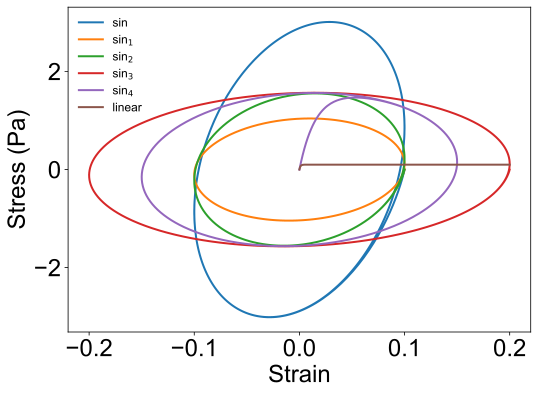

In [13]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial
plt.rcParams['font.size'] = 24
%config InlineBackend.figure_format = 'svg'
# 定义 calc_stress 函数
def calc_stress(E, eta, strain_func, N, T):
    """
    计算应力和应变
    :param E: 弹性模量
    :param eta: 粘性系数
    :param strain_func: 应变函数，输入为时间，输出为应变
    :param N: 时间步数
    :param T: 总时间
    :return: 时间序列, 应变序列, 应力序列
    """
    time = np.linspace(0, T, N)  # 生成时间序列
    strain = strain_func(time)  # 根据应变函数生成应变序列
    strain_rate=np.zeros(N)
    stress = np.zeros(N)  # 初始化应力序列
    for i in range(1, N):
        de = strain[i] - strain[i-1]  # 应变增量
        dt = time[i] - time[i-1]  # 时间增量
        stress[i] = ((1 - dt / (eta / E)) * stress[i-1] + E * de)  # 计算应力
        strain_rate[i]=de/dt
    
    return time, strain, stress*100,strain_rate

# 定义不同的应变函数
def strain_sin(time):
    """ 正弦应变函数 """
    return epsilon_0 * np.cos(omega * time)

def strain_sin1(time):
  
   return epsilon_0 * np.cos(omega * time/3)

def strain_sin2(time):
    
    return epsilon_0 * np.cos(omega * time/2)
def strain_sin3(time):
    return 2*epsilon_0 * np.cos(omega * time/4)
def strain_sin4(time):
    return 1.5*epsilon_0 * np.sin(omega * time/3)
def strain_linear(time):
    return  epsilon_0 * time/10  # 线性增加的应变
# 参数
E = 1.0  # 弹性模量
eta = 0.1  # 粘性系数
epsilon_0 = 0.1  # 最大应变
omega = np.pi  # 角频率
T = 2 * np.pi / omega  # 周期
N = 2000  # 时间步数

# 创建Excel写入器
writer = pd.ExcelWriter('data/sin_maxwell_protocols_data.xlsx', engine='xlsxwriter')

# 绘制应力-应变曲线
fig, ax = plt.subplots(figsize=(8, 6), dpi=600)

# 定义应变函数列表
strain_functions = [
    ('sin', strain_sin),
    ('sin$_{1}$', strain_sin1),
    ('sin$_{2}$', strain_sin2),
    ('sin$_{3}$', strain_sin3),
    ('sin$_{4}$',strain_sin4),
    ('linear',strain_linear)
]
n=1
for name, strain_func in strain_functions:
    # 计算应力-应变数据
    time, strain, stress,strain_rate = calc_stress(E, eta, strain_func, N, 10 * T)
    
    # 创建DataFrame
    data = pd.DataFrame({'Time': time, 'Strain': strain, 'Stress': stress,'n':[n]*len(time),'Strain_rate':strain_rate})
    n=n+1
    # 将数据写入Excel文件的不同工作簿
    data.to_excel(writer, sheet_name=name, index=False)
    
    # 绘制曲线
    ax.plot(strain, stress, label=f'{name}', linewidth=2)

# 保存Excel文件
writer.close()

ax.set_xlabel('Strain')
ax.set_ylabel('Stress (Pa)')
ax.legend(loc='upper left', frameon=False,fontsize=12)
plt.tight_layout()
plt.savefig('pic/maxwell_moni.pdf', dpi=600)
plt.show()

In [13]:
# 读取Excel文件
file_path = 'data/sin_maxwell_data.xlsx'
df = pd.read_excel(file_path, sheet_name=0)  # 读取第一个工作簿

# 打印前10行数据
print(df.head(10))

FileNotFoundError: [Errno 2] No such file or directory: 'data/sin_maxwell_data.xlsx'